In [0]:
import pandas as pd
from sklearn import metrics

In [0]:
df =pd.read_csv("104403553_data_new.csv")

## 前處理

### 做attribute list之後比較好叫
1. crossing_gk_list 做平均用的
2. not_gk_list是所有跟守門員無關的數據
3. gk_attribute_list是跟守門有關的屬性

In [0]:
crossing_gk_list = ['Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing','BallControl','Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina','Strength','LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure','Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes'] 
not_gk_attribute_list = ['Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing','BallControl','Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina','Strength','LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure','Marking','StandingTackle','SlidingTackle'] 
gk_attribute_list = ['GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes'] 

## 把34個屬性加在一起得到一個sum欄位
另外兩個欄位是為了做加分題弄的，分別在之後的x,y軸出現

In [0]:
df['sum'] = df[crossing_gk_list].mean(axis=1)
df['not_gk_mean'] = df[not_gk_attribute_list].mean(axis=1)
df['gk_mean'] = df[gk_attribute_list].mean(axis=1)
plot_list = ['Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing','BallControl','Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina','Strength','LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure','Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes','not_gk_mean','gk_mean'] 

## 把大家的sum 欄位做平均
只要這位球員的sum值高於平均，他就是above_average player
<br>在這邊使用apply來完成

In [0]:
rating_avg = df['sum'].mean()
df['avg'] = df['sum'].apply(lambda x : 'Above-Average Players' if x >= rating_avg else 'Below-Average Players')

In [0]:
x = df.loc[:,plot_list]
y = df.loc[:,['avg']]

## 簡單的transform

In [0]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y_class_label=le.fit_transform(y['avg'])


## 看看資料分布
因為後面繪圖都是在守門員屬性跟不是守門員屬性當x,y軸，所以先來看看真正的分布是怎樣


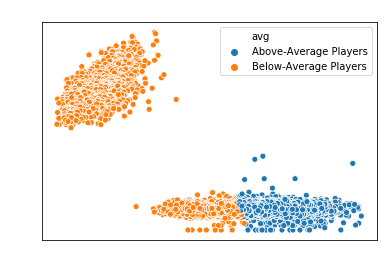

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

title = plt.title('Below/Above Average Distribution')
plt.setp(title, color='w')
#matplotlib.rc('axes',edgecolor='w')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
#plt.ylabel.label.set_color("red")
label_x = plt.xlabel("Non GK attributes")
label_x.set_color("white")

label_y = plt.ylabel("GK attributes")
label_y.set_color("white")
sns.scatterplot(x = df['not_gk_mean'],y = df['gk_mean'], hue = y['avg'])
#scatter = plt.scatter(df['not_gk_mean'],df['gk_mean'], c = y_class_label, alpha = 0.5, edgecolor= 'w')
#plt.legend(['ac' , 'ca'])

plt.show()

## 切分資料集

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y_class_label, test_size=0.33)

為了之後畫圖看的出來是哪幾個店分類措

In [0]:
def confusion_classifier(ground, predicted):
  if ground == 0 and predicted == 0:
    value = 'Predicted Correctly'
  elif ground == 0 and predicted == 1:
    value = 'Wrong'
  elif ground == 1 and predicted == 0:
    value = 'Wrong'
  elif ground == 1 and predicted == 1:
    value = 'Predicted Correctly'
  
  return value
    

## Naive Bayes
如果甚麼都不做的naive bayes會是0.85<br>
所以我把拿來train 跟 test的 attribute做稍為的修正，
把守門員有關的數據都砍掉。
之所以知道這麼做原因是因為<br>
如果回朔資料集，可以清楚看見，即使最好的守門員，也是below_average球員。其實是因為守門員的其他數據都很爛。

In [0]:
nb_x_train = x_train.loc[:,not_gk_attribute_list]
nb_x_test = x_test.loc[:,not_gk_attribute_list]

In [12]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(nb_x_train, y_train)
nb_predicted = nb_model.predict(nb_x_test)
print("Accuracy")
print(metrics.accuracy_score(y_test, nb_predicted))
print("Naive Bayes Classification Report:")
print(metrics.classification_report(y_test, nb_predicted))

Accuracy
0.9117303520774237
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      3381
           1       0.95      0.84      0.89      2612

    accuracy                           0.91      5993
   macro avg       0.92      0.90      0.91      5993
weighted avg       0.92      0.91      0.91      5993



In [13]:
print("Naive Bayes Confusion Matrix")
pd.crosstab(y_test, nb_predicted, rownames=["Actual"], colnames=["Predicted"])

Naive Bayes Confusion Matrix


Predicted,0,1
Actual,,
0,3273,108
1,421,2191


## 為了搞清楚哪幾點是有問題的做的

In [0]:
df_nb = pd.DataFrame()
df_nb['groundtruth'] = y_test
df_nb['predicted'] = nb_predicted
df_nb['state'] = df_nb.apply(lambda x: confusion_classifier(x['groundtruth'], x['predicted']), axis=1)

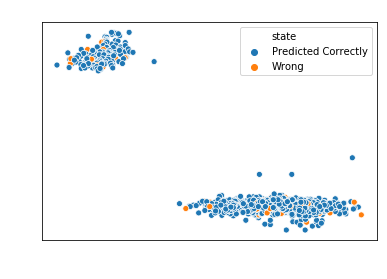

In [15]:
import matplotlib
import matplotlib.pyplot as plt2

title = plt2.title('Below/Above Average Distribution Naive Bayes')
plt2.setp(title, color='w')
#matplotlib.rc('axes',edgecolor='w')
plt2.tick_params(axis='x', colors='white')
plt2.tick_params(axis='y', colors='white')
#plt.ylabel.label.set_color("red")
label_x = plt2.xlabel("Non GK attributes")
label_x.set_color("white")

label_y = plt2.ylabel("GK attributes")
label_y.set_color("white")
sns.scatterplot(x = x_test['not_gk_mean'],y = x_test['gk_mean'], hue = df_nb['state'])
#plt2.scatter(x_test['not_gk_mean'],x_test['gk_mean'], c = df_nb['state'], alpha = 0.5, edgecolor= 'w')

plt2.legend()
plt2.show()

## Decision Tree
decision tree 不用再特殊處理就可以找到0.9以上了<br>
深度、葉子數量做微調，就可以了。<br>
這邊我用entropy 來做information gain，深度12<br>
大概把深度從10-20都試過一遍

In [0]:
dt_x_train = x_train.loc[:,crossing_gk_list]
dt_x_test = x_test.loc[:,crossing_gk_list]

In [17]:
from sklearn import tree
dt_model = tree.DecisionTreeClassifier(criterion = 'entropy',max_depth=12)
dt_model.fit(dt_x_train, y_train)
dt_predicted = dt_model.predict(dt_x_test)
print("Accuracy")
print(metrics.accuracy_score(y_test, dt_predicted))
print("Decision Tree Classification Report:")
print(metrics.classification_report(y_test, dt_predicted))

Accuracy
0.9062239279159019
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3381
           1       0.89      0.89      0.89      2612

    accuracy                           0.91      5993
   macro avg       0.90      0.90      0.90      5993
weighted avg       0.91      0.91      0.91      5993



In [18]:
print("Decision Tree Confusion Matrix")
pd.crosstab(y_test, dt_predicted, rownames=["Actual"], colnames=["Predicted"])

Decision Tree Confusion Matrix


Predicted,0,1
Actual,,
0,3095,286
1,276,2336


In [0]:
df_dt = pd.DataFrame()
df_dt['groundtruth'] = y_test
df_dt['predicted'] = dt_predicted
df_dt['state'] = df_dt.apply(lambda x: confusion_classifier(x['groundtruth'], x['predicted']), axis=1)

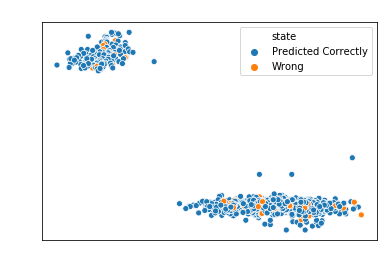

In [20]:
import matplotlib
import matplotlib.pyplot as plt3

title = plt3.title('Below/Above Average Distribution Decision Tree')
plt3.setp(title, color='w')
#matplotlib.rc('axes',edgecolor='w')
plt3.tick_params(axis='x', colors='white')
plt3.tick_params(axis='y', colors='white')
#plt.ylabel.label.set_color("red")
label_x = plt3.xlabel("Non GK attributes")
label_x.set_color("white")

label_y = plt3.ylabel("GK attributes")
label_y.set_color("white")
sns.scatterplot(x = x_test['not_gk_mean'],y = x_test['gk_mean'], hue = df_dt['state'])
#plt2.scatter(x_test['not_gk_mean'],x_test['gk_mean'], c = df_nb['state'], alpha = 0.5, edgecolor= 'w')

plt3.legend()
plt3.show()

## Logistic Regression
Logistic Regression 感覺上基本上怎樣都會猜對<br>
用愈複雜的分類方法，開始愈來愈厲害，
用邏輯是回歸就有0.97了

In [0]:
lr_x_train = x_train.loc[:,crossing_gk_list]
lr_x_test = x_test.loc[:,crossing_gk_list]

In [22]:
from sklearn.linear_model import LogisticRegression as LR
lr_model = LR(solver = 'liblinear')
lr_model.fit(lr_x_train, y_train)
lr_predicted = lr_model.predict(lr_x_test)
print("Accuracy")
print(metrics.accuracy_score(y_test, lr_predicted))
print("Logistic Regression Classification Report:")
print(metrics.classification_report(y_test, lr_predicted))

Accuracy
0.9684632070749207
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3381
           1       0.97      0.96      0.96      2612

    accuracy                           0.97      5993
   macro avg       0.97      0.97      0.97      5993
weighted avg       0.97      0.97      0.97      5993



In [23]:
print("Logistic Regression Confusion Matrix")
pd.crosstab(y_test, lr_predicted, rownames=["Actual"], colnames=["Predicted"])

Logistic Regression Confusion Matrix


Predicted,0,1
Actual,,
0,3307,74
1,115,2497


In [0]:
df_lr = pd.DataFrame()
df_lr['groundtruth'] = y_test
df_lr['predicted'] = lr_predicted
df_lr['state'] = df_lr.apply(lambda x: confusion_classifier(x['groundtruth'], x['predicted']), axis=1)

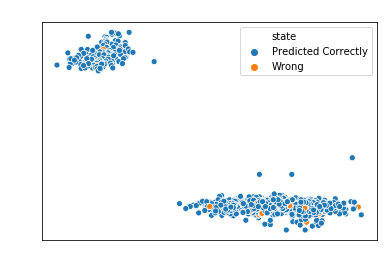

In [25]:
import matplotlib
import matplotlib.pyplot as plt4

title = plt3.title('Below/Above Average Distribution Logistic Regression')
plt4.setp(title, color='w')
#matplotlib.rc('axes',edgecolor='w')
plt4.tick_params(axis='x', colors='white')
plt4.tick_params(axis='y', colors='white')
#plt.ylabel.label.set_color("red")
label_x = plt4.xlabel("Non GK attributes")
label_x.set_color("white")

label_y = plt4.ylabel("GK attributes")
label_y.set_color("white")
sns.scatterplot(x = x_test['not_gk_mean'],y = x_test['gk_mean'], hue = df_lr['state'])
#plt2.scatter(x_test['not_gk_mean'],x_test['gk_mean'], c = df_nb['state'], alpha = 0.5, edgecolor= 'w')

plt4.legend()
plt4.show()

## SVM
來到最厲害的SVM，使用LINEAR kernel
這個svm沒有特別作甚麼東西，就有1.0的準確率<br>
保留前面的scaling，是因為有做scaling反而不如沒做的，有做scaling的有32個錯誤，沒做卻只有8個。<br>
當然這個這麼厲害可能只是因為這次train_test_split剛好分到這樣，但是無論如何svm真的很神。
<br>
另外還有試試rbf，但是沒有linear厲害。

In [0]:
svm_x_train = x_train.loc[:,crossing_gk_list]
svm_x_test = x_test.loc[:,crossing_gk_list]

In [0]:
scaler = preprocessing.StandardScaler()
scaled_x_train = scaler.fit_transform(svm_x_train)
scaled_x_test = scaler.fit_transform(svm_x_test)

In [28]:
from sklearn.svm import SVC
svm_model = SVC(kernel = 'linear')
svm_model.fit(svm_x_train, y_train)
svm_predicted = svm_model.predict(svm_x_test)
print("Accuracy")
print(metrics.accuracy_score(y_test, svm_predicted))
print("SVM Classification Report:")
print(metrics.classification_report(y_test, svm_predicted))

Accuracy
0.9989988319706324
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3381
           1       1.00      1.00      1.00      2612

    accuracy                           1.00      5993
   macro avg       1.00      1.00      1.00      5993
weighted avg       1.00      1.00      1.00      5993



In [29]:
print("SVM Confusion Matrix")
pd.crosstab(y_test, svm_predicted, rownames=["Actual"], colnames=["Predicted"])

SVM Confusion Matrix


Predicted,0,1
Actual,,
0,3376,5
1,1,2611


In [0]:
df_svm = pd.DataFrame()
df_svm['groundtruth'] = y_test
df_svm['predicted'] = svm_predicted
df_svm['state'] = df_lr.apply(lambda x: confusion_classifier(x['groundtruth'], x['predicted']), axis=1)

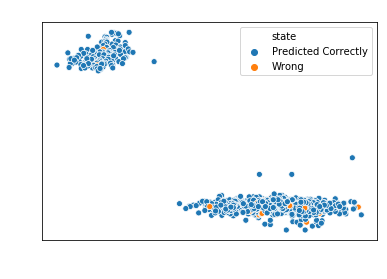

In [31]:
import matplotlib
import matplotlib.pyplot as plt5

title = plt3.title('Below/Above Average Distribution SVM')
plt5.setp(title, color='w')
#matplotlib.rc('axes',edgecolor='w')
plt5.tick_params(axis='x', colors='white')
plt5.tick_params(axis='y', colors='white')
#plt.ylabel.label.set_color("red")
label_x = plt5.xlabel("Non GK attributes")
label_x.set_color("white")

label_y = plt5.ylabel("GK attributes")
label_y.set_color("white")
sns.scatterplot(x = x_test['not_gk_mean'],y = x_test['gk_mean'], hue = df_svm['state'])
#plt2.scatter(x_test['not_gk_mean'],x_test['gk_mean'], c = df_nb['state'], alpha = 0.5, edgecolor= 'w')

plt5.legend()
plt5.show()

## KNN
我想說都做梅西跟內馬爾，就順便把c羅一起做一做吧<br>
身為一個資深球迷，很興奮來看看fifa19做出來的nearest neighbor跟心中一不一樣


有點懶得先把球員列出來，先顯示陣列，等等在印出名字

In [0]:
knn_x = x.loc[:,crossing_gk_list]

In [33]:
from sklearn.neighbors import NearestNeighbors
knn_model = NearestNeighbors(n_neighbors=6)
knn_model.fit(knn_x)
m_c_n_x = knn_x.iloc[0:3]
neighbors = knn_model.kneighbors(m_c_n_x, return_distance=False) 
neighbors = neighbors.tolist()
print(neighbors)


[[0, 2, 15, 5, 154, 23], [1, 23, 10, 25, 33, 122], [2, 5, 0, 15, 157, 154]]


第一個球員，就是那個被分析的球員，因為最近

In [34]:
for i in range(len(neighbors[2])):
  player_id = neighbors[2][i]
  print(df.iloc[player_id]['Name'])
  
print()

for i in range(len(neighbors[0])):
  player_id = neighbors[0][i]
  print(df.iloc[player_id]['Name'])

print()
for i in range(len(neighbors[1])):
  player_id = neighbors[1][i]
  print(df.iloc[player_id]['Name'])

Neymar Jr
E. Hazard
L. Messi
P. Dybala
Ronaldo Cabrais
A. Robben

L. Messi
Neymar Jr
P. Dybala
E. Hazard
A. Robben
S. Agüero

Cristiano Ronaldo
S. Agüero
R. Lewandowski
K. Mbappé
P. Aubameyang
F. Thauvin


## KNN結論
身為一個有再踢球跟看球的人來說，從直覺上，這個結論是可以接受的，雖然有些還是怪怪<br>
怎麼說呢?<BR>
可以看見的是三個球員的香球員基本上都是前鋒型球員。所以基本上可以看出來，大家的數據再資料集裡面，應該某些屬性是真的滿類似的(eg: 射門、跑動速度、控球...等。)。而且相似的球員都是球星等集的球員。<br>
比較可惜的是，這些球員，雖然都是前鋒，但是由於資料集的限制，我們並看不出來球風上的差別。舉例來說，就我看來，messi的球風根neymar事天差地遠的，但是在這個資料集裡面做knn，卻發現相似度很高。因為他們都很矮，在頭頂那邊，不如C羅好，造成他們相似度高。

## NN and Linear Regression(加分)
因為平常也有在玩足球遊戲，而球員薪水常常是讓人很頭痛很煩的事情。球員的薪資是不是給高了這件事情，是相當在意的，或者自己喜歡的球員是不是給低了。<br>
因此，我針對近十年討論度最高的(就是連沒踢球的人都知道的球星)球員，評斷一下是不是給高或給低了。<br>
所以說，我就用了類神經網路跟線性回歸回歸看看，還有用最簡單的線性回歸來做薪水猜測。

In [0]:
#nn_crossing_gk_list = ['Age','Skill Moves','Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing','BallControl','Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina','Strength','LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure','Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes'] 
nn_train = df.iloc[3:18159]
nn_mcn = df.iloc[0:3]
nn_x_train = nn_train[crossing_gk_list]
nn_y_train = nn_train['Wage']

## NN這邊發生甚麼事
想要用一個類神經網路，來回歸球員薪水這個事情。這個神經網路的設計，沒經過甚麼很複雜的思考，只是覺得就這樣設吧。跑出來的結果，感覺有點不好就是了啦。


In [36]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
#create model
nn_model = Sequential()

#get number of columns in training data
n_cols = nn_x_train.shape[1]

#add model layers
nn_model.add(Dense(32, activation='relu', input_shape=(n_cols,)))
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(1))

Using TensorFlow backend.
W0615 08:28:02.878020 140347961624448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 08:28:02.912305 140347961624448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0615 08:28:02.918926 140347961624448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0615 08:28:03.030980 140347961624448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instea

In [37]:
nn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

W0615 08:28:03.079672 140347961624448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



early_stopping就是一個不是用epoch把大家停下來的機制，在這裡原本以為會很適合，就用了，誰知道用了好像沒什麼顯著的差別。

In [38]:
from keras.callbacks import EarlyStopping
#set early stopping monitor so the model stops training when it won't improve anymore
#early_stopping_monitor = EarlyStopping(patience=5)
#train model
#callbacks=[early_stopping_monitor]
history = nn_model.fit(nn_x_train, nn_y_train, validation_split=0.1, epochs=10,batch_size =20)

W0615 08:28:03.378405 140347961624448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 16340 samples, validate on 1816 samples
Epoch 1/10
16340/16340 [==============================] - 8s 504us/step - loss: 459310493.2913 - val_loss: 1908872.2208
Epoch 2/10
16340/16340 [==============================] - 4s 272us/step - loss: 424475791.8984 - val_loss: 5369007.0639
Epoch 3/10
16340/16340 [==============================] - 4s 272us/step - loss: 400826580.0747 - val_loss: 5643650.3018
Epoch 4/10
16340/16340 [==============================] - 4s 273us/step - loss: 390965243.5520 - val_loss: 9589568.1278
Epoch 5/10
16340/16340 [==============================] - 4s 270us/step - loss: 388145461.9994 - val_loss: 11023059.1327
Epoch 6/10
16340/16340 [==============================] - 5s 277us/step - loss: 381103693.1824 - val_loss: 6565627.3320
Epoch 7/10
16340/16340 [==============================] - 4s 269us/step - loss: 375476116.0006 - val_loss: 5811033.7294
Epoch 8/10
16340/16340 [==============================] - 4s 263us/step - loss: 371667929.9376 - val_loss: 298

這張表看起來好像不能代表甚麼。

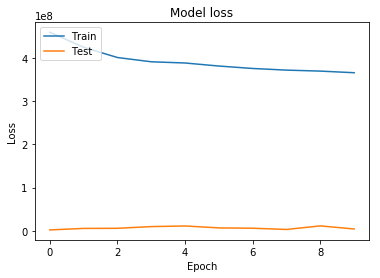

In [39]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

0: Messi
1: C羅
2: Neymar

看的出來，Neymar的薪水被嚴重低估。基本上，我覺得ground truth對於Neymar就不是很公平了。但是還是難掩飾這是一個比較不好的類神經網路範例。


In [40]:
print("NN")
nn_model.predict(df.iloc[0:3][crossing_gk_list])


NN


array([[53344.52],
       [49621.95],
       [53294.3 ]], dtype=float32)

In [41]:
print("ground truth")
df.iloc[0:3]["Wage"]

ground truth


0    565000
1    405000
2    290000
Name: Wage, dtype: int64

線性回歸看起來正常多。<BR>
 他認為梅西應該薪水最高，在來c羅，在來Neymar。三個人的球技數據，來說fifa給的薪水都有點低估了。尤其是Neymar的數據。我不知道為甚麼fifa給Neymar這麼低的薪水，有點怪。真實世界裡面Neymar的薪水比事跟另外兩位依樣高的。

In [42]:
print("linear regression")
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression().fit(nn_x_train, nn_y_train)
linear_model.predict(df.iloc[0:3][crossing_gk_list])

linear regression


array([51665.9293302 , 51639.31957489, 48239.47656302])